In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload
import matplotlib.pyplot as plt

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

from tensorboardX import SummaryWriter
%load_ext line_profiler

In [2]:
model_params = params.params_dict['MNIST'](augm_flag=True, batch_size=128)
base_model = model_params.base_model

X = []
for i, (x, _) in enumerate(model_params.train_loader):
    if i>100:
        break;
    X.append( x.view(-1, 784) )
X = torch.cat(X, 0)
# metric = models.PCAMetric( X, p=2, min_sv_factor=10000)

device = torch.device('cuda:2')

In [3]:
# base_model = torch.load('SavedModels/base_MNIST_lr0.001_augm_flagTrue_train_typeACET.pth')
# gmm = torch.load('SavedModels/GMM/gmm_MNIST_n1000_data_used60000_augm_flagTrue_alg_scikit.pth')
# gmm = models.GMM(100, 784, metric=metric)

gmm = models.GMM(100, 784)
gmm.find_solution(X, initialize=True, iterate=False, use_kmeans=False, verbose=False)

In [4]:
#gmm_helpers.rescale(gmm, 5, model_params.cali_loader)
lam = gmm_helpers.find_lam(gmm, 1, model_params.cali_loader)
print(lam)

-1403.49697265625


In [35]:
#lam = -911.408
gmm.alpha = nn.Parameter(gmm.alpha)
gmm.mu.requires_grad = True
gmm.logvar.requires_grad = True
gmm.alpha.requires_grad = (False)

model = models.RobustModel(base_model, gmm, lam, dim=model_params.dim).to(device)
model.loglam.requires_grad = False

In [36]:
lr = 0.001
lr_gmm = .001

param_groups = [{'params':model.mm.mu,'lr':lr_gmm, 'weight_decay':0.},
                {'params':model.mm.logvar,'lr':0.1*lr_gmm, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':5e-4}]
optimizer = optim.SGD(param_groups,  momentum=.9)

In [24]:
ran = torch.rand(50, 1, 28, 28, device=device)
_, (data, target) = enumerate(model_params.train_loader).__next__()
data, target = data.to(device), target.to(device)

noise_loader = model_params.loaders[-1][1]
_, (noise, _) = enumerate(noise_loader).__next__()
noise = noise.to(device)

In [38]:
for epoch in range(5):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
    print( model.mm.logvar.exp().sqrt().mean() )
    print( model.mm.mu.mean() )
    print(torch.logsumexp(model.mm(ran.view(ran.shape[0],-1)), 0).mean().item())
    print(torch.logsumexp(model.mm(data.view(data.shape[0],-1)), 0).mean().item())
    print(torch.logsumexp(model.mm(noise.view(noise.shape[0],-1)), 0).mean().item())
    trainloss = tt.train_CEDA_gmm(model, device, model_params.cali_loader, 
                                  model_params.loaders[-1][1], 
                                  optimizer, epoch, verbose=200)
    print(trainloss)

tensor(1.2981, device='cuda:2', grad_fn=<MeanBackward1>)
tensor(0.5006, device='cuda:2', grad_fn=<MeanBackward1>)
-10.85886001586914
-11.407681465148926
-11.218962669372559
Train Epoch: 0 [0/60000 (0%)]	Loss: 4.619010
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.272465
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.590617
tensor(1.2979, device='cuda:2', grad_fn=<MeanBackward1>)
tensor(0.5006, device='cuda:2', grad_fn=<MeanBackward1>)
12.595541954040527
13.104945182800293
13.265920639038086
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.458662
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.364121
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.267267
tensor(1.2977, device='cuda:2', grad_fn=<MeanBackward1>)
tensor(0.5005, device='cuda:2', grad_fn=<MeanBackward1>)
25.65390968322754
26.580551147460938
26.730932235717773
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.176035
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.178463
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.173433
tensor(1.2974, device='cuda:2', grad_fn=<MeanBackwa

In [95]:
#model.mm.logvar.data-=.1
print(torch.logsumexp(model.mm(ran.view(50,-1)), 0).min())
print(torch.logsumexp(model.mm(data.view(128,-1)), 0).min())

tensor(-598.4886, device='cuda:2', grad_fn=<MinBackward1>)
tensor(-586.4437, device='cuda:2', grad_fn=<MinBackward1>)


In [9]:
lam = 0.

In [40]:
model.loglam.data = torch.tensor(328.896019897461, device=device)
print( model(ran).max(1)[0].exp() )

RuntimeError: CUDA error: an illegal memory access was encountered

In [13]:
correct, av_conf, test_loss = tt.test(model.base_model, device, model_params.test_loader)
print(correct)
print(av_conf)
print(test_loss)

correct_combined, av_conf_combined, test_loss_combined = tt.test(model, device, model_params.test_loader)
print(correct_combined)
print(av_conf_combined)
print(test_loss_combined)

0.9582
0.943073314666748
0.13513391060829164
0.9582
0.9430732063293457
0.1351339080810547


In [53]:
lr = 0.001

param_groups = [{'params':model.mm.mu,'lr':lr, 'weight_decay':0.},
                {'params':model.mm.logvar,'lr':0.1*lr, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':5e-4}]
optimizer = optim.SGD(param_groups,  momentum=.9)

In [56]:
_, (data, target) = enumerate(model_params.train_loader).__next__()
noise = enumerate(noise_loader).__next__()[1][0]
data, target = data.to(device), target.to(device)

noise = noise.to(device)

criterion = nn.NLLLoss()
optimizer.zero_grad()
output = model(data)

output_adv = model(noise)
print(F.nll_loss(output, target))
loss = F.nll_loss(output, target) - output_adv.max(1)[0].sum()/(noise_loader.batch_size)

print(loss)
loss.backward()
optimizer.step()
print(model.mm.mu.grad.abs().max())
print(model.mm.logvar.grad.abs().max(0))

tensor(2.0517, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(2.0617, device='cuda:2', grad_fn=<SubBackward0>)
tensor(0.0006, device='cuda:2')
(tensor(3.8104, device='cuda:2'), tensor(32, device='cuda:2'))


In [52]:
gmm.logvar.exp().sqrt().mean()

tensor(7.2830, device='cuda:2', grad_fn=<MeanBackward1>)

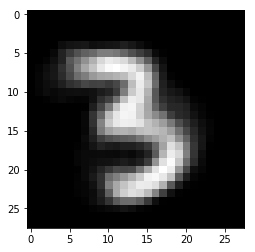

In [9]:
plt.imshow(gmm.mu[15].view(28,28).detach().cpu(), cmap='gray')

In [24]:
print(torch.logsumexp(model.mm(ran.view(50,-1)), 0).mean().item())
print(torch.logsumexp(model.mm(data.view(128,-1)), 0).mean().item())
print(torch.logsumexp(model.mm(noise.view(noise.shape[0],-1)), 0).mean().item())

-127.35750579833984
630.4345703125
808.810791015625


In [23]:
print(model(noise).max(1)[0].exp())

tensor([0.1586, 0.1670, 0.1642, 0.2598, 0.1587, 0.4193, 0.2773, 0.1616, 0.1587,
        0.1809, 0.1604, 0.1585, 0.1616, 0.1591, 0.1596, 0.2225, 0.1673, 0.9921,
        0.1599, 0.1604, 0.7428, 0.1603, 0.1941, 0.2065, 0.1588, 0.2051, 0.1699,
        0.1583, 0.1618, 0.2338, 0.1599, 0.1531, 0.1861, 0.1620, 0.1750, 0.1601,
        0.1674, 0.1756, 0.1784, 0.1665, 0.3809, 0.1593, 0.9205, 0.1748, 0.1600,
        0.2581, 0.1703, 0.1741, 0.1676, 0.1662, 0.1585, 0.1598, 0.1652, 0.1757,
        0.2948, 0.1600, 0.2896, 0.1910, 0.1751, 0.1584, 0.1742, 0.1584, 0.2519,
        0.1686, 0.1586, 0.5145, 0.5003, 0.6875, 0.1619, 0.3584, 0.1585, 0.1584,
        0.1612, 0.1744, 0.6987, 0.1721, 0.1638, 0.2366, 0.1603, 0.1595, 0.3666,
        0.1667, 0.1972, 0.1626, 0.1818, 0.2467, 0.1606, 0.1596, 0.1591, 0.1669,
        0.1700, 0.1631, 0.2257, 0.2074, 0.1715, 0.1597, 0.1585, 0.1626, 0.1586,
        0.3179, 0.8841, 0.1807, 0.2252, 0.1649, 0.4515, 0.1614, 0.1670, 0.1807,
        0.1745, 0.1593, 0.1785, 0.1578, 

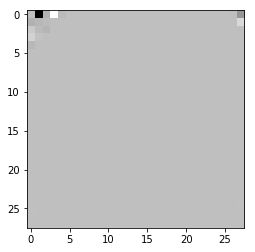

In [31]:
plt.imshow(metric.comp_vecs[-1].view(28, 28), cmap='gray')

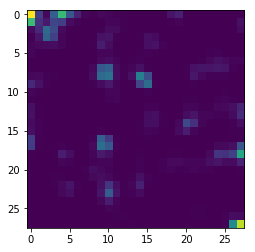

In [41]:
plt.imshow(noise[0][0].detach().cpu())

In [69]:
M2 = metric(gmm.mu[None,:,:], gmm.mu[:,None,:]).cpu()

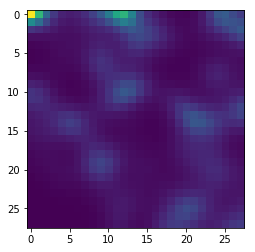

In [52]:
plt.imshow(noise[0][0].detach().cpu())

In [3]:
ds = dl.CIFAR100(train=True, augm_flag=True)

In [4]:
ds.dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Split: train
    Root Location: ../data
    Transforms (if any): RandomChoice(
                             Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomCrop(size=(32, 32), padding=4)
                             ToTensor()
                         )
                             Compose(
                             ToTensor()
                         )
                         )
    Target Transforms (if any): None